In [265]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from copy import deepcopy
from sklearn.preprocessing import StandardScaler

from robustDA import process_cmip6, processing, anchor_regression, plots, hypothesis_testing

%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [751]:
params_climate = {
        "temporalRes": "ann",
        "variables": ["tas"],
        "scenarios": ["historical", "piControl"],
        "startDate": 1850,
        "endDate": 2014,
        "target": "aerosols",
        "anchor": "co2",
    }

params_anchor = {
        "gamma": [1, 10, 100, 1000, 10000],
        "h_anchors":['square'],
    }

In [752]:
target = params_climate["target"]
anchor = params_climate["anchor"]
startDate = params_climate["startDate"]
endDate = params_climate["endDate"]

gamma = params_anchor["gamma"]
h_anchors = params_anchor["h_anchors"]

In [530]:
modelsDataList, modelsInfoFrame = process_cmip6.read_files_cmip6(params_climate)

modelsInfoFrame.head()

,filename,var,temporalRes,modelFull,model,scenario,spatialRes
0,tas_ann_ACCESS-CM2_historical_r1i1p1f1_g025.nc,tas,ann,ACCESS-CM2,ACC,historical,g025
1,tas_ann_ACCESS-CM2_piControl_r1i1p1f1_g025.nc,tas,ann,ACCESS-CM2,ACC,piControl,g025
2,tas_ann_ACCESS-ESM1-5_historical_r1i1p1f1_g025.nc,tas,ann,ACCESS-ESM1-5,ACC,historical,g025
3,tas_ann_ACCESS-ESM1-5_piControl_r1i1p1f1_g025.nc,tas,ann,ACCESS-ESM1-5,ACC,piControl,g025
4,tas_ann_AWI-CM-1-1-MR_historical_r1i1p1f1_g025.nc,tas,ann,AWI-CM-1-1-MR,AWI,historical,g025


In [610]:
dict_models = processing.split_train_test(modelsDataList, modelsInfoFrame, 
                                          params_climate["target"], params_climate["anchor"])

print(dict_models['trainModels'])
print(dict_models['testModels'])

X_train = dict_models["X_train"]
y_train = dict_models["y_train"]
y_anchor_train = dict_models["y_anchor_train"]

X_test = dict_models["X_test"]
y_test = dict_models["y_test"]
y_anchor_test = dict_models["y_anchor_test"]

['ACC' 'BCC' 'CAS' 'CMC' 'E3S' 'EC-' 'FGO' 'IIT' 'INM' 'MCM' 'MPI' 'MRI'
 'NES' 'Tai']
['AWI' 'CAM' 'CES' 'CIE' 'Can' 'FIO' 'GFD' 'GIS' 'IPS' 'KIO' 'MIR' 'Nor'
 'SAM']


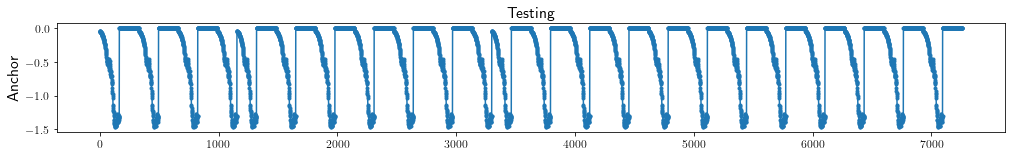

In [567]:
fig = plt.figure(figsize = (17,2))
plt.plot(np.array(y_test), '.-')
plt.ylabel("Anchor")
plt.title("Testing");

In [568]:
np.std(y_test)

0    0.508902
dtype: float64

In [126]:
lambdaSel, mse_df, corr_pearson, mi, lambdasCV = anchor_regression.cross_validation_anchor_regression(
    modelsDataList,
    modelsInfoFrame,
    deepcopy(dict_models),
    params_climate,
    gamma,
    h_anchors,
    30,
    sel_method="MSE",
    display_CV_plot=True)

In [130]:
lambdaSel

array([ 0.23950266,  5.73615251, 10.82636734, 38.56620421])

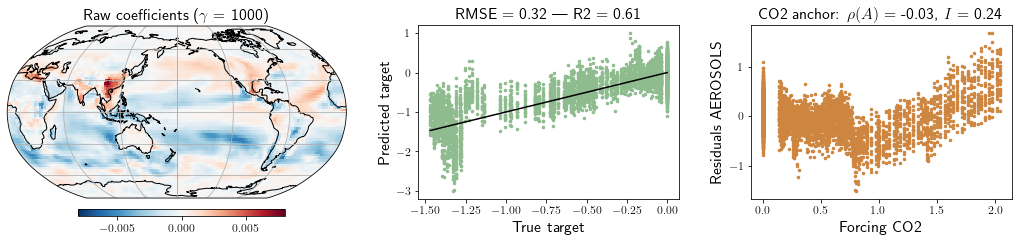

In [540]:
coefRaw, y_test_pred, mse = anchor_regression.anchor_regression_estimator(
    dict_models, gamma, h_anchors, 38, method = "direct")
anchor_regression.make_plots(dict_models, coefRaw, y_test_pred, dict_models["y_anchor_test"],
        gamma, params_climate["target"], params_climate["anchor"], h_anchors, filename = "aer_co2_gamma1000.pdf")

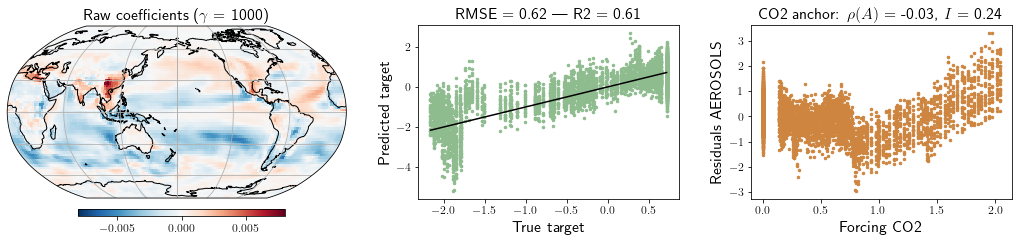

In [605]:
coefRaw, y_test_true, y_test_pred, mse = anchor_regression.anchor_regression_estimator(
    dict_models, gamma, h_anchors, 38, method = "ridge")
anchor_regression.make_plots(dict_models, coefRaw, y_test_true, y_test_pred, dict_models["y_anchor_test"],
        gamma, params_climate["target"], params_climate["anchor"], h_anchors, filename = "aer_co2_gamma1000.pdf")

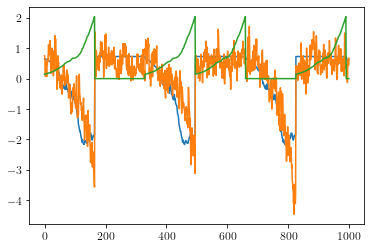

In [611]:
# y1 = y_test_pred
plt.plot(y_test_true[:1000])
plt.plot(y_test_pred[:1000])
plt.plot(y_anchor_test.values[:1000])

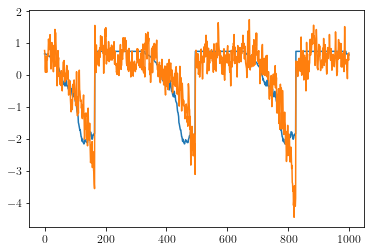

In [606]:
plt.plot(y_test_true[:1000])
plt.plot(y_test_pred[:1000])

In [595]:
np.std(y_test_true)

1.0

In [578]:
y_test_pred.shape

(7260, 1)

In [583]:
np.std(y_test_pred*np.std(y_train.values))

0.5342164580598546

In [86]:
fig.savefig("./../output/figures/aer_co2_gamma1.pdf")

<Figure size 432x288 with 0 Axes>

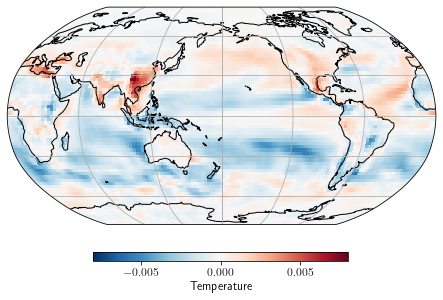

In [573]:
fig = plt.figure();
plots.plotMapCartopy(coefRaw.reshape((72,144)), cLim = None);

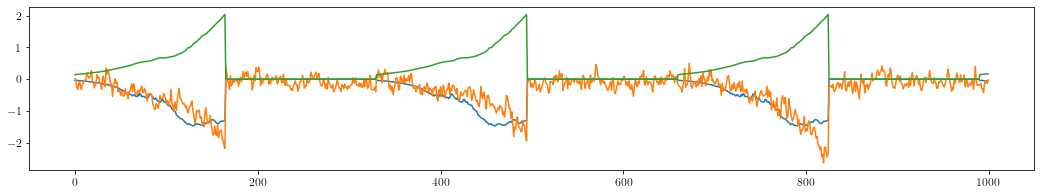

In [542]:
fig = plt.figure(figsize = (18, 3))
plt.plot(y_test.values[:1000])
plt.plot(y_test_pred[:1000]);
plt.plot(y_anchor_test.values[:1000])

In [ ]:
import pickle
filename = ("./../output/data/subagging_" + target + "_" + anchor + "_gamma_" + str(gamma) + "_square_noAhstd.pkl")
with open(filename, 'rb') as f:
    lambdaSel_runs, coefRaw_runs, mse_runs_df, corr_pearson_runs, mi_runs, y_test_pred_runs, \
            ts_null, ts_alt = pickle.load(f)

In [226]:
X_train = dict_models["X_train"]
y_train = dict_models["y_train"]
y_anchor_train = dict_models["y_anchor_train"]

X_test = dict_models["X_test"]
y_test = dict_models["y_test"]
y_anchor_test = dict_models["y_anchor_test"]

# Create a scaler object
sc_X = StandardScaler(with_mean=True, with_std=True)
sc_y = StandardScaler(with_mean=True, with_std=True)
sc_X_test = StandardScaler(with_mean=True, with_std=True)
sc_y_test = StandardScaler(with_mean=True, with_std=True)

# Fit the scaler to the data and transform
X_train_std = sc_X.fit_transform(X_train.values)
y_train_std = sc_y.fit_transform(y_train.values)
X_test_std = sc_X_test.fit_transform(X_test.values)
y_test_std = sc_y_test.fit_transform(y_test.values)

### Hypothesis testing

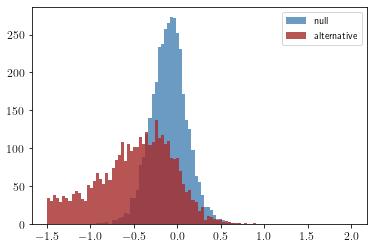

In [89]:
y_null = np.array([]).reshape(-1,1)
nbYears = params_climate["endDate"] - params_climate["startDate"] + 1
for i in range(len(dict_models["testFiles"])):
    if dict_models["testFiles"][i].split("_")[3] == "piControl":
        y_null = np.concatenate((y_null, y_test_pred[i * nbYears + 1: (i+1) * nbYears]))
        
y_alt = np.array([]).reshape(-1,1)
nbYears = params_climate["endDate"] - params_climate["startDate"] + 1
for i in range(len(dict_models["testFiles"])):
    if dict_models["testFiles"][i].split("_")[3] != "piControl":
        y_alt = np.concatenate((y_alt, y_test_pred[i * nbYears + 1: (i+1) * nbYears]))
        
bins = np.linspace(-1.5, 2, 100)
plt.hist(y_null, bins, alpha = 0.8, color = "steelblue", label = 'null');
plt.hist(y_alt, bins, alpha = 0.8, color = "brown", label = 'alternative');
plt.legend();

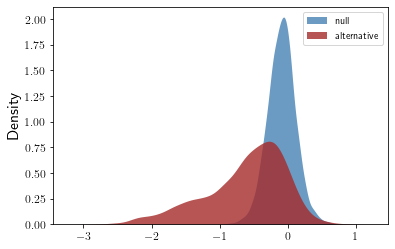

In [90]:
sns.kdeplot(y_null.reshape(-1), fill = True, alpha=.8, linewidth=0, color = "steelblue", label = "null");
sns.kdeplot(y_alt.reshape(-1), fill = True, alpha=.8, linewidth=0, color = "brown", label = "alternative");
plt.legend();

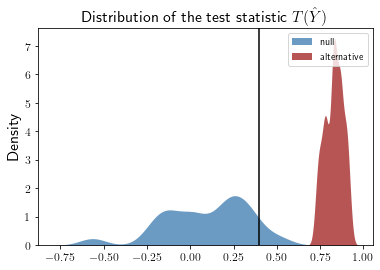

In [92]:
sns.kdeplot(ts_null, bw_method = 0.3, fill = True, color = "steelblue", alpha=.8, linewidth=0, label = "null");
sns.kdeplot(ts_alt, bw_method = 0.3, fill = True, color = "brown", alpha=.8, linewidth=0, label = "alternative");
plt.axvline(np.quantile(ts_null, q = 0.95), 0, 1.4, color = 'k')
plt.xlabel("")
plt.title("Distribution of the test statistic $T(\hat{Y})$")
# plt.yscale("log")
plt.legend();

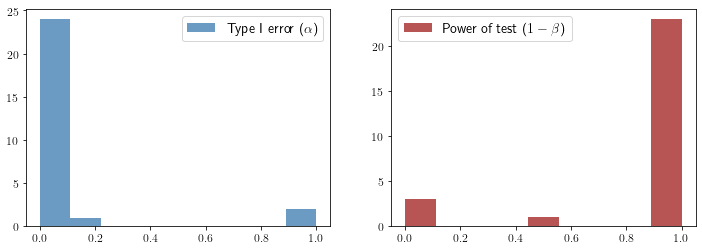

In [1041]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4))
bins = np.linspace(0, 1, 10)
ax1.hist(alpha_bagging.reshape(-1), bins, fill = True, alpha=.8, linewidth=0, color = "steelblue", label = "Type I error ($\\alpha$)");
ax1.legend(fontsize = 14)
ax2.hist(power_bagging.reshape(-1), bins, fill = True, alpha=.8, linewidth=0, color = "brown", label = "Power of test ($1-\\beta$)");
ax2.legend(fontsize = 14);

In [1040]:
import pickle
filename = ("./../output/data/HT_aerosols_co2_K_3.pkl")
with open(filename, 'rb') as f:
    h_anchors, gamma_vals, lambda_vals, ind_gamma_opt, ind_lambda_opt, gamma_opt, lambda_opt, ind_vect_ideal_obj1, ind_vect_ideal_obj2, coef_raw_opt, y_test_true, y_test_pred, y_anchor_test, \
        rmse, corr, mi, alpha_bagging, power_bagging, nb_models_bagging, models = pickle.load(f)

In [1042]:
gamma_opt

array([[10000.],
       [ 1000.],
       [10000.]])

In [1043]:
lambda_opt

array([[31.6227766],
       [31.6227766],
       [31.6227766]])

In [1001]:
alpha_bagging

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.33333333,
       0.        , 0.5       , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        ])

In [1002]:
power_bagging

array([1.        , 1.        , 0.        , 0.66666667, 0.5       ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.83333333, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [1003]:
nb_models_bagging

array([3., 2., 1., 3., 2., 4., 1., 3., 2., 3., 4., 3., 2., 3., 3., 3., 2.,
       2., 1., 1., 1., 1., 3., 4., 3., 3., 2.])

<Figure size 432x288 with 0 Axes>

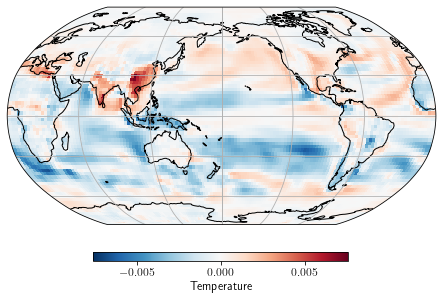

In [1004]:
fig = plt.figure();
plots.plotMapCartopy(coef_raw_opt[0,:].reshape((72,144)), cLim = None);

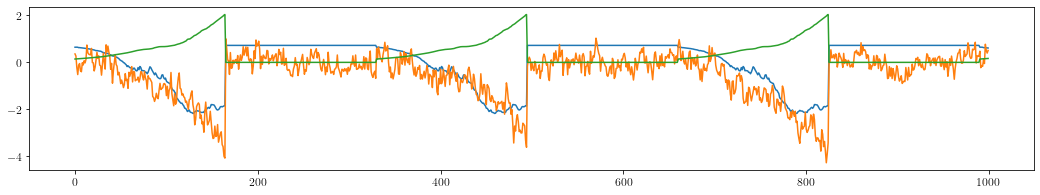

In [1005]:
fig = plt.figure(figsize = (18,3))
plt.plot(np.array(list(flatten(y_test_true))).reshape(-1,1)[:1000])
plt.plot(np.array(list(flatten(y_test_pred))).reshape(-1,1)[:1000])
plt.plot(np.array(list(flatten(y_anchor_test))).reshape(-1,1)[:1000])

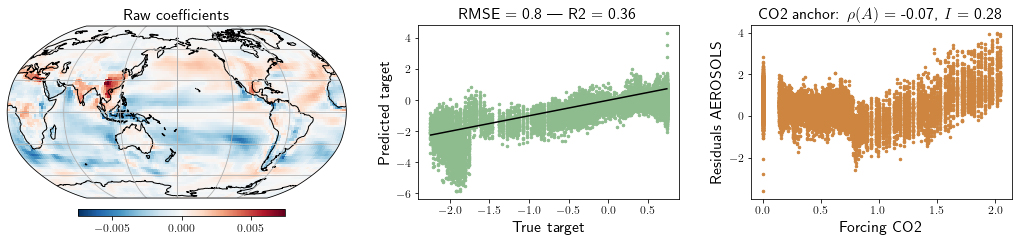

In [1044]:
from pandas.core.common import flatten
plots.make_plots_HT(dict_models, np.mean(coef_raw_opt, axis = 0), np.array(list(flatten(y_test_true))).reshape(-1,1), np.array(list(flatten(y_test_pred))).reshape(-1,1), 
                    np.array(list(flatten(y_anchor_test))).reshape(-1,1),
        params_climate["target"], params_climate["anchor"], h_anchors, filename = "aer_co2.pdf")

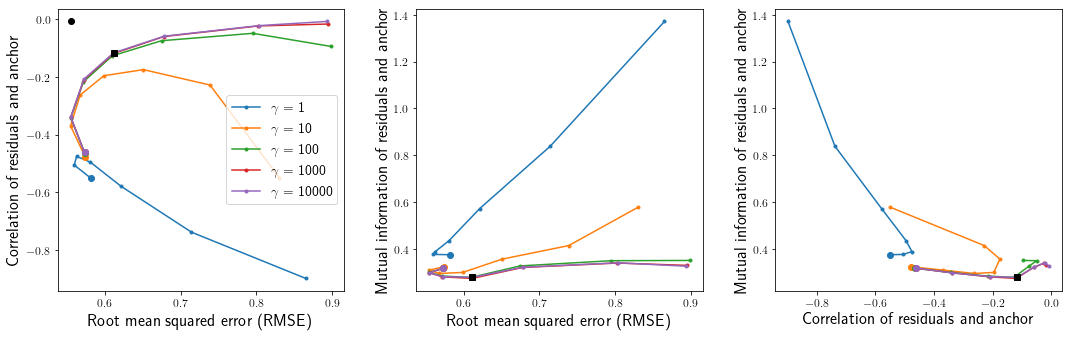

In [1064]:
rmse_bagging = np.mean(rmse, axis = 0)
corr_bagging = np.mean(corr, axis = 0)
mi_bagging = np.mean(mi, axis = 0)

from statistics import mode
i1 = int(mode(list(ind_gamma_opt.reshape(-1))))
i2 = int(mode(list(ind_lambda_opt.reshape(-1))))
iv1 = np.array([int(mode(list(ind_vect_ideal_obj1[:,0]))), int(mode(list(ind_vect_ideal_obj1[:,1])))])
iv2 = np.array([int(mode(list(ind_vect_ideal_obj2[:,0]))), int(mode(list(ind_vect_ideal_obj2[:,1])))])

# ind_opt_gamma, ind_opt_lambda, ind_vect_ideal_obj1, ind_vect_ideal_obj2 = anchor_regression.choose_gamma_lambda_pareto(
#     rmse_bagging, corr_bagging, maxX=True, maxY=True, plot=False, objective1=None, objective2=None
# )

plots.plot_Pareto(
    rmse_bagging,
    corr_bagging,
    mi_bagging,
    h_anchors,
    gamma_vals,
    lambda_vals,
    i1,
    i2,
    iv1, iv2,
    filename=None)